[View in Colaboratory](https://colab.research.google.com/github/jsxyhelu/DateSets/blob/master/%E5%9F%BA%E7%A1%80_cifar10_%E5%BA%8F%E8%B4%AF.ipynb)

发现这段官方的代码，给出的就是带argumentation的结果

In [1]:
'''Train a simple deep CNN on the CIFAR10 small images dataset.

It gets to 75% validation accuracy in 25 epochs, and 79% after 50 epochs.
(it's still underfitting at that point, though).
'''

from __future__ import print_function
# !apt-get -qq install -y graphviz && pip install -q pydot
import pydot
import keras
import cv2
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils.vis_utils import plot_model
import matplotlib.image as image # image 用于读取图片
import matplotlib.pyplot as plt
import os

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

E:\Anaconda3\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
batch_size = 128
num_classes = 10
epochs = 5
#epochs = 3
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [3]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model2 = Sequential()
model2.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model2.add(Activation('relu'))
model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(512))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(num_classes))
model2.add(Activation('softmax'))

In [9]:
#显示模型
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

(2065, 523, 4)


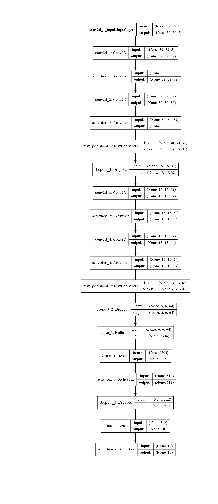

In [10]:
plot_model(model,to_file='model1.png',show_shapes=True)
img = image.imread('model1.png')
print(img.shape)
plt.imshow(img) # 显示图片
plt.axis('off') # 不显示坐标轴
plt.show()

In [5]:
# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model2.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    #使用了数据自动增长
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4)
    
    model2.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4)

Using real-time data augmentation.
Epoch 1/5
391/391 [==============================] - 18s 47ms/step - loss: 1.9888 - acc: 0.2645 - val_loss: 1.7352 - val_acc: 0.3868
Epoch 2/5
391/391 [==============================] - 16s 41ms/step - loss: 1.7432 - acc: 0.3707 - val_loss: 1.5904 - val_acc: 0.4255
Epoch 3/5
391/391 [==============================] - 15s 40ms/step - loss: 1.6290 - acc: 0.4055 - val_loss: 1.4674 - val_acc: 0.4745
Epoch 4/5
391/391 [==============================] - 16s 40ms/step - loss: 1.5414 - acc: 0.4401 - val_loss: 1.3679 - val_acc: 0.5056
Epoch 5/5
391/391 [==============================] - 16s 40ms/step - loss: 1.4907 - acc: 0.4596 - val_loss: 1.3115 - val_acc: 0.5329
Epoch 1/5
391/391 [==============================] - 14s 35ms/step - loss: 1.8894 - acc: 0.3182 - val_loss: 1.6162 - val_acc: 0.4385
Epoch 2/5
391/391 [==============================] - 13s 34ms/step - loss: 1.6428 - acc: 0.4104 - val_loss: 1.4590 - val_acc: 0.4843
Epoch 3/5
391/391 [===============

In [6]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at E:\OctaveProject\cs231n\DateSets\saved_models\keras_cifar10_trained_model.h5 


In [7]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 2s 154us/step
Test loss: 1.311544268989563
Test accuracy: 0.5329


In [8]:
scores = model2.evaluate(x_test, y_test, verbose=1)
print('Test loss2:', scores[0])
print('Test accuracy2:', scores[1])

10000/10000 [==============================] - 1s 122us/step
Test loss2: 1.2602598337173463
Test accuracy2: 0.5492
